In [ ]:
# Install Required Packages
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")
    except subprocess.CalledProcessError:
        print(f"❌ Failed to install {package}")

# List of required packages
required_packages = [
    "scikit-learn",
    "xgboost", 
    "matplotlib",
    "seaborn",
    "joblib",
    "pandas",
    "numpy"
]

print("🔧 Installing required packages...")
for package in required_packages:
    install_package(package)

print("\n🎉 All packages installed! You can now run the rest of the notebook.")

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re

# Enhanced text preprocessing function
def enhanced_text_preprocessing(text):
    """Enhanced text preprocessing with better feature extraction"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Extract years of experience (if mentioned)
    experience_pattern = r'(\d+)\s*(?:years?|yrs?)\s*(?:of\s*)?(?:experience|exp)'
    experience_match = re.search(experience_pattern, text)
    if experience_match:
        text += f" experience_years_{experience_match.group(1)}"
    
    # Extract education level
    education_keywords = {
        'phd': 'doctorate_level',
        'ph.d': 'doctorate_level',
        'doctorate': 'doctorate_level',
        'm.s': 'masters_level',
        'm.tech': 'masters_level',
        'mba': 'masters_level',
        'masters': 'masters_level',
        'b.tech': 'bachelors_level',
        'b.s': 'bachelors_level',
        'b.e': 'bachelors_level',
        'bachelors': 'bachelors_level'
    }
    
    for edu_key, edu_level in education_keywords.items():
        if edu_key in text:
            text += f" {edu_level}"
    
    # Extract company tier (FAANG, Fortune 500, etc.)
    faang_companies = ['google', 'apple', 'facebook', 'amazon', 'netflix', 'microsoft', 'meta']
    for company in faang_companies:
        if company in text:
            text += " tier1_company"
            break
    
    # Remove special characters but keep important programming symbols
    text = re.sub(r'[^\w\s\+\#\.]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Load the enhanced comprehensive dataset
print("📊 Loading enhanced comprehensive dataset...")
df = pd.read_csv("D:\\ML IA3 PROJECT\\comprehensive_resume_dataset.csv")
print(f"Dataset loaded: {len(df)} resumes across {df['Category'].nunique()} categories")
print(f"Categories: {', '.join(df['Category'].unique())}")
print(f"Distribution: {dict(df['Category'].value_counts())}")

# Apply enhanced preprocessing
print("🔧 Applying enhanced text preprocessing...")
df['Resume_processed'] = df['Resume'].apply(enhanced_text_preprocessing)

# Enhanced TF-IDF vectorization
print("🔧 Creating enhanced TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=5000,  # Increased feature count
    ngram_range=(1, 3),  # Include trigrams
    min_df=1,
    max_df=0.95,
    stop_words='english',
    sublinear_tf=True,
    norm='l2'
)

X = vectorizer.fit_transform(df['Resume_processed'])

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

print(f"✅ Feature matrix shape: {X.shape}")
print(f"✅ Number of classes: {len(label_encoder.classes_)}")

# Split dataset with stratification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")

📊 Loading enhanced comprehensive dataset...
Dataset loaded: 129 resumes across 9 categories
Categories: Data Science, Software Engineer, Frontend Developer, Backend Developer, Machine Learning Engineer, DevOps Engineer, Full Stack Developer, Web Developer, Product Manager
Distribution: {'Frontend Developer': 15, 'Backend Developer': 15, 'Machine Learning Engineer': 15, 'DevOps Engineer': 15, 'Full Stack Developer': 15, 'Web Developer': 15, 'Product Manager': 15, 'Software Engineer': 14, 'Data Science': 10}
🔧 Applying enhanced text preprocessing...
🔧 Creating enhanced TF-IDF features...
✅ Feature matrix shape: (129, 5000)
✅ Number of classes: 9
📊 Training set: 90 samples
📊 Test set: 39 samples
📊 Training set: 90 samples
📊 Test set: 39 samples


In [2]:
# Enhanced Fine-Tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("🔄 Fine-tuning Logistic Regression...")

# Enhanced parameter grid
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [500, 1000, 2000],
    'class_weight': [None, 'balanced']
}

# Initialize model
log_reg = LogisticRegression(random_state=42)

# Calculate appropriate CV folds
min_class_size = np.bincount(y_train).min()
cv_folds = min(5, min_class_size)
print(f"Using {cv_folds}-fold cross-validation")

# GridSearchCV for best parameters
grid_search = GridSearchCV(
    log_reg, 
    param_grid, 
    cv=cv_folds, 
    scoring='f1_weighted', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best Parameters
print("✅ Best parameters:", grid_search.best_params_)
print("✅ Best cross-validation score:", grid_search.best_score_)

# Train the model with best params
best_log_reg = grid_search.best_estimator_

# Evaluate on test set
y_pred_log = best_log_reg.predict(X_test)
accuracy_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log, average='weighted')

print(f"📊 Test Accuracy: {accuracy_log:.4f}")
print(f"📊 Test F1 Score: {f1_log:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))

🔄 Fine-tuning Logistic Regression...
Using 5-fold cross-validation
Fitting 5 folds for each of 90 candidates, totalling 450 fits
✅ Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'lbfgs'}
✅ Best cross-validation score: 0.7103703703703703
📊 Test Accuracy: 0.7692
📊 Test F1 Score: 0.7596

📋 Classification Report:
                           precision    recall  f1-score   support

        Backend Developer       0.50      0.50      0.50         4
             Data Science       0.67      0.67      0.67         3
          DevOps Engineer       1.00      1.00      1.00         4
       Frontend Developer       1.00      0.80      0.89         5
     Full Stack Developer       0.62      1.00      0.77         5
Machine Learning Engineer       0.80      0.80      0.80         5
          Product Manager       1.00      1.00      1.00         4
        Software Engineer       0.50      0.25      0.33         4
            Web Developer       0.80      0.80  

In [3]:
# Enhanced Fine-Tuning for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

print("🔄 Fine-tuning Random Forest...")

# Enhanced parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Initialize model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized Search (more efficient for large parameter space)
random_search = RandomizedSearchCV(
    rf, 
    param_grid, 
    cv=cv_folds, 
    scoring='f1_weighted', 
    n_jobs=-1, 
    n_iter=50,  # Increased iterations for better exploration
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

# Best parameters
print("✅ Best parameters:", random_search.best_params_)
print("✅ Best cross-validation score:", random_search.best_score_)

# Train with best params
best_rf = random_search.best_estimator_

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"📊 Test Accuracy: {accuracy_rf:.4f}")
print(f"📊 Test F1 Score: {f1_rf:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Feature importance analysis
feature_names = vectorizer.get_feature_names_out()
importances = best_rf.feature_importances_
top_features_idx = np.argsort(importances)[-20:][::-1]

print("\n🔍 Top 20 Most Important Features:")
for i, idx in enumerate(top_features_idx, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} - {importances[idx]:.4f}")

🔄 Fine-tuning Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': None, 'bootstrap': False}
✅ Best cross-validation score: 0.8074074074074075
📊 Test Accuracy: 0.8205
📊 Test F1 Score: 0.8046

📋 Classification Report:
                           precision    recall  f1-score   support

        Backend Developer       0.60      0.75      0.67         4
             Data Science       1.00      0.67      0.80         3
          DevOps Engineer       0.80      1.00      0.89         4
       Frontend Developer       0.80      0.80      0.80         5
     Full Stack Developer       0.71      1.00      0.83         5
Machine Learning Engineer       0.83      1.00      0.91         5
          Product Manager       1.00      1.00      1.00         4
        Software Engineer       1.00      0.25      0.40         4
        

In [4]:
# Enhanced Fine-Tuning for XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("🔄 Fine-tuning XGBoost...")

# Enhanced parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 2]
}

# Initialize model
xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1
)

# Grid Search with reduced parameter combinations for efficiency
from sklearn.model_selection import RandomizedSearchCV

random_search_xgb = RandomizedSearchCV(
    xgb_model, 
    param_grid, 
    cv=cv_folds, 
    scoring='f1_weighted', 
    n_jobs=-1,
    n_iter=30,  # Reasonable number for XGBoost
    random_state=42,
    verbose=1
)

random_search_xgb.fit(X_train, y_train)

# Best parameters
print("✅ Best parameters:", random_search_xgb.best_params_)
print("✅ Best cross-validation score:", random_search_xgb.best_score_)

# Train with best params
best_xgb = random_search_xgb.best_estimator_

# Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"📊 Test Accuracy: {accuracy_xgb:.4f}")
print(f"📊 Test F1 Score: {f1_xgb:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# Feature importance analysis
feature_names = vectorizer.get_feature_names_out()
importances = best_xgb.feature_importances_
top_features_idx = np.argsort(importances)[-20:][::-1]

print("\n🔍 Top 20 Most Important Features (XGBoost):")
for i, idx in enumerate(top_features_idx, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} - {importances[idx]:.4f}")

🔄 Fine-tuning XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\dicks\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [18:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
✅ Best cross-validation score: 0.725
📊 Test Accuracy: 0.7949
📊 Test F1 Score: 0.7842

📋 Classification Report:
                           precision    recall  f1-score   support

        Backend Developer       0.50      0.75      0.60         4
             Data Science       0.50      0.67      0.57         3
          DevOps Engineer       1.00      1.00      1.00         4
       Frontend Developer       0.75      0.60      0.67         5
     Full Stack Developer       0.83      1.00      0.91         5
Machine Learning Engineer       0.83      1.00      0.91         5
          Product Manager       1.00      1.00      1.00         4
        Software Engineer       1.00      0.25      0.40         4
            Web Developer       1.00      0.80      0.89         5

                 accuracy                           0.79 

In [5]:
# Model Comparison and Ensemble Creation
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

print("🔄 Creating Ensemble Model and Final Comparison...")

# Create ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', best_log_reg),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'  # Use probability predictions
)

# Train ensemble
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble
y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')

print(f"📊 Ensemble Test Accuracy: {accuracy_ensemble:.4f}")
print(f"📊 Ensemble Test F1 Score: {f1_ensemble:.4f}")

# Cross-validation scores for all models
models = {
    'Logistic Regression': best_log_reg,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'Ensemble': ensemble_model
}

results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': accuracy_score(y_test, model.predict(X_test)),
        'test_f1': f1_score(y_test, model.predict(X_test), average='weighted')
    }

# Display results
print("\n" + "="*60)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*60)

for name, result in results.items():
    print(f"\n🔹 {name}:")
    print(f"   Cross-Validation: {result['cv_mean']:.4f} ± {result['cv_std']:.4f}")
    print(f"   Test Accuracy:    {result['test_accuracy']:.4f}")
    print(f"   Test F1 Score:    {result['test_f1']:.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_f1'])
print(f"\n🏆 Best Model: {best_model_name}")
print(f"🎯 Best F1 Score: {results[best_model_name]['test_f1']:.4f}")

# Store best model for saving
if best_model_name == 'Ensemble':
    final_best_model = ensemble_model
elif best_model_name == 'Random Forest':
    final_best_model = best_rf
elif best_model_name == 'XGBoost':
    final_best_model = best_xgb
else:
    final_best_model = best_log_reg

🔄 Creating Ensemble Model and Final Comparison...


C:\Users\dicks\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [18:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Ensemble Test Accuracy: 0.8205
📊 Ensemble Test F1 Score: 0.8086


C:\Users\dicks\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [18:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\dicks\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [18:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\dicks\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [18:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us


📊 COMPREHENSIVE MODEL COMPARISON

🔹 Logistic Regression:
   Cross-Validation: 0.7222 ± 0.0497
   Test Accuracy:    0.7692
   Test F1 Score:    0.7596

🔹 Random Forest:
   Cross-Validation: 0.8222 ± 0.0648
   Test Accuracy:    0.8205
   Test F1 Score:    0.8046

🔹 XGBoost:
   Cross-Validation: 0.7556 ± 0.0667
   Test Accuracy:    0.7949
   Test F1 Score:    0.7842

🔹 Ensemble:
   Cross-Validation: 0.7778 ± 0.0497
   Test Accuracy:    0.8205
   Test F1 Score:    0.8086

🏆 Best Model: Ensemble
🎯 Best F1 Score: 0.8086


In [6]:
# Save Enhanced Fine-Tuned Models
import joblib
import os

print("💾 Saving enhanced fine-tuned models...")

# Create directories if they don't exist
os.makedirs("D:/ML IA3 PROJECT/models", exist_ok=True)
os.makedirs("D:/ML IA3 PROJECT/saved_models", exist_ok=True)

# Save fine-tuned models
models_to_save = {
    'Logistic_Regression_Enhanced': best_log_reg,
    'Random_Forest_Enhanced': best_rf,
    'XGBoost_Enhanced': best_xgb,
    'Ensemble_Enhanced': ensemble_model
}

for model_name, model in models_to_save.items():
    # Save to both directories
    joblib.dump(model, f"D:/ML IA3 PROJECT/models/{model_name}.joblib")
    joblib.dump(model, f"D:/ML IA3 PROJECT/saved_models/{model_name}.joblib")
    print(f"✅ {model_name} saved successfully")

# Save enhanced preprocessing components
joblib.dump(vectorizer, "D:/ML IA3 PROJECT/models/vectorizer_enhanced.joblib")
joblib.dump(label_encoder, "D:/ML IA3 PROJECT/models/label_encoder_enhanced.joblib")

joblib.dump(vectorizer, "D:/ML IA3 PROJECT/saved_models/vectorizer_enhanced.joblib")
joblib.dump(label_encoder, "D:/ML IA3 PROJECT/saved_models/label_encoder_enhanced.joblib")

print("✅ Enhanced vectorizer and label encoder saved")

# Also save the original format for backward compatibility
joblib.dump(best_log_reg, "D:/ML IA3 PROJECT/saved_models/Logistic_Regression_Tuned.joblib")
joblib.dump(best_rf, "D:/ML IA3 PROJECT/saved_models/Random_Forest_Tuned.joblib")
joblib.dump(best_xgb, "D:/ML IA3 PROJECT/saved_models/XGBoost_Tuned.joblib")

# Save preprocessing components in original format
joblib.dump(vectorizer, "D:/ML IA3 PROJECT/saved_models/vectorizer.joblib")
joblib.dump(label_encoder, "D:/ML IA3 PROJECT/saved_models/label_encoder.joblib")

print("✅ Backward compatibility models saved")
print("\n🎉 All models and components saved successfully!")

💾 Saving enhanced fine-tuned models...
✅ Logistic_Regression_Enhanced saved successfully
✅ Random_Forest_Enhanced saved successfully
✅ XGBoost_Enhanced saved successfully
✅ Ensemble_Enhanced saved successfully
✅ Enhanced vectorizer and label encoder saved
✅ Ensemble_Enhanced saved successfully
✅ Enhanced vectorizer and label encoder saved
✅ Backward compatibility models saved

🎉 All models and components saved successfully!
✅ Backward compatibility models saved

🎉 All models and components saved successfully!


In [7]:
# Enhanced Model Evaluation and Analysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Enhanced Model Evaluation...")

# Load the enhanced models (just saved)
enhanced_models = {
    "Logistic Regression Enhanced": joblib.load("D:/ML IA3 PROJECT/saved_models/Logistic_Regression_Enhanced.joblib"),
    "Random Forest Enhanced": joblib.load("D:/ML IA3 PROJECT/saved_models/Random_Forest_Enhanced.joblib"),
    "XGBoost Enhanced": joblib.load("D:/ML IA3 PROJECT/saved_models/XGBoost_Enhanced.joblib"),
    "Ensemble Enhanced": joblib.load("D:/ML IA3 PROJECT/saved_models/Ensemble_Enhanced.joblib")
}

# Comprehensive evaluation
print("="*80)
print("📋 ENHANCED MODEL PERFORMANCE ANALYSIS")
print("="*80)

for model_name, model in enhanced_models.items():
    print(f"\n🔹 {model_name}")
    print("-" * 50)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"📊 Test Accuracy: {accuracy:.4f}")
    print(f"📊 F1 Score:      {f1:.4f}")
    
    # Detailed classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Model comparison summary
print("\n" + "="*80)
print("🏆 MODEL RANKING SUMMARY")
print("="*80)

model_performance = []
for model_name, model in enhanced_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_performance.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1_Score': f1
    })

# Sort by F1 score
model_performance.sort(key=lambda x: x['F1_Score'], reverse=True)

print("Rank | Model                          | Accuracy | F1 Score")
print("-" * 65)
for i, perf in enumerate(model_performance, 1):
    print(f"{i:2d}   | {perf['Model']:30s} | {perf['Accuracy']:8.4f} | {perf['F1_Score']:8.4f}")

best_model = model_performance[0]
print(f"\n🥇 Champion: {best_model['Model']}")
print(f"🎯 Best F1 Score: {best_model['F1_Score']:.4f}")
print(f"🎯 Best Accuracy: {best_model['Accuracy']:.4f}")

📊 Enhanced Model Evaluation...
📋 ENHANCED MODEL PERFORMANCE ANALYSIS

🔹 Logistic Regression Enhanced
--------------------------------------------------
📊 Test Accuracy: 0.7692
📊 F1 Score:      0.7596

📋 Classification Report:
                           precision    recall  f1-score   support

        Backend Developer       0.50      0.50      0.50         4
             Data Science       0.67      0.67      0.67         3
          DevOps Engineer       1.00      1.00      1.00         4
       Frontend Developer       1.00      0.80      0.89         5
     Full Stack Developer       0.62      1.00      0.77         5
Machine Learning Engineer       0.80      0.80      0.80         5
          Product Manager       1.00      1.00      1.00         4
        Software Engineer       0.50      0.25      0.33         4
            Web Developer       0.80      0.80      0.80         5

                 accuracy                           0.77        39
                macro avg       0.7

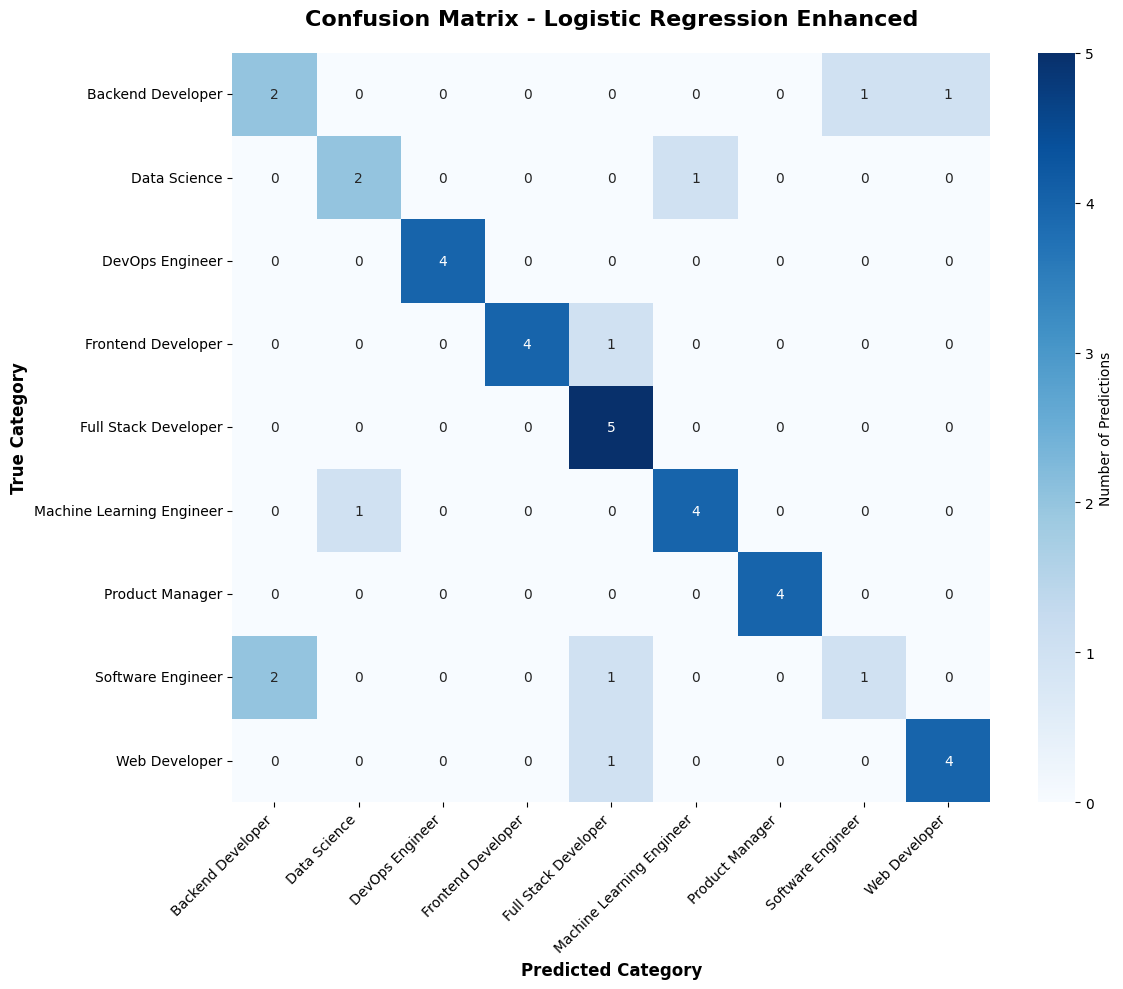


📊 Per-Class Accuracy for Logistic Regression Enhanced:
--------------------------------------------------
Backend Developer        : 0.5000 (50.0%)
Data Science             : 0.6667 (66.7%)
DevOps Engineer          : 1.0000 (100.0%)
Frontend Developer       : 0.8000 (80.0%)
Full Stack Developer     : 1.0000 (100.0%)
Machine Learning Engineer: 0.8000 (80.0%)
Product Manager          : 1.0000 (100.0%)
Software Engineer        : 0.2500 (25.0%)
Web Developer            : 0.8000 (80.0%)


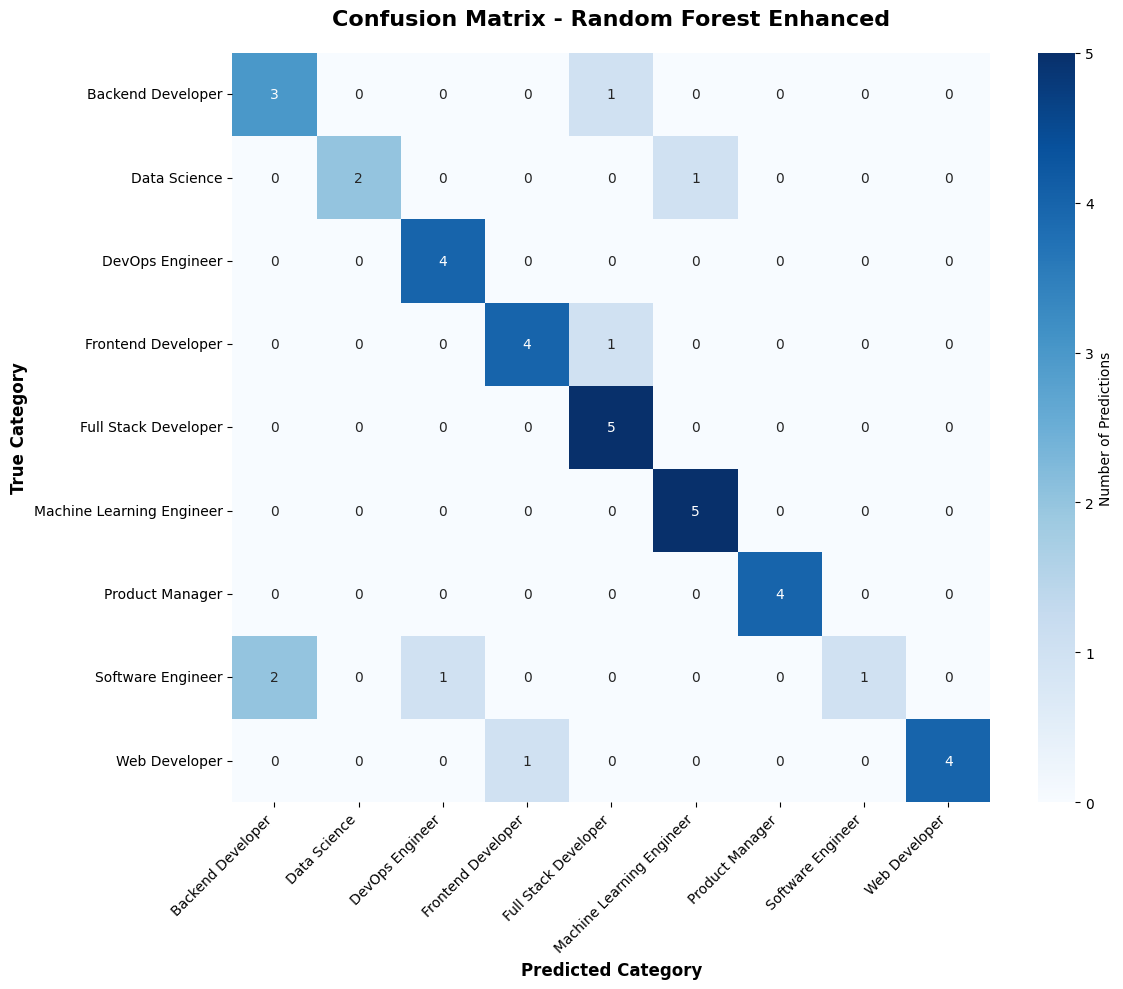


📊 Per-Class Accuracy for Random Forest Enhanced:
--------------------------------------------------
Backend Developer        : 0.7500 (75.0%)
Data Science             : 0.6667 (66.7%)
DevOps Engineer          : 1.0000 (100.0%)
Frontend Developer       : 0.8000 (80.0%)
Full Stack Developer     : 1.0000 (100.0%)
Machine Learning Engineer: 1.0000 (100.0%)
Product Manager          : 1.0000 (100.0%)
Software Engineer        : 0.2500 (25.0%)
Web Developer            : 0.8000 (80.0%)


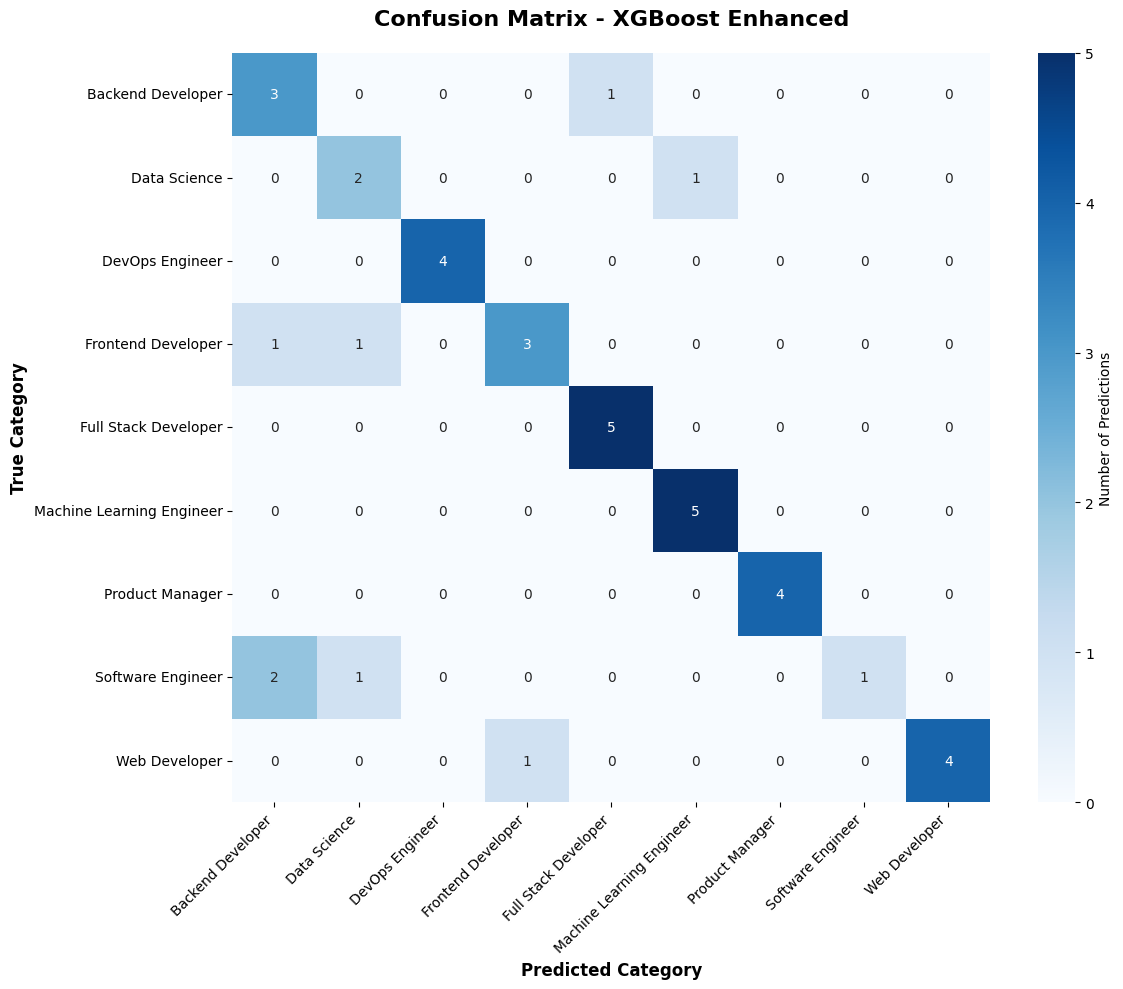


📊 Per-Class Accuracy for XGBoost Enhanced:
--------------------------------------------------
Backend Developer        : 0.7500 (75.0%)
Data Science             : 0.6667 (66.7%)
DevOps Engineer          : 1.0000 (100.0%)
Frontend Developer       : 0.6000 (60.0%)
Full Stack Developer     : 1.0000 (100.0%)
Machine Learning Engineer: 1.0000 (100.0%)
Product Manager          : 1.0000 (100.0%)
Software Engineer        : 0.2500 (25.0%)
Web Developer            : 0.8000 (80.0%)


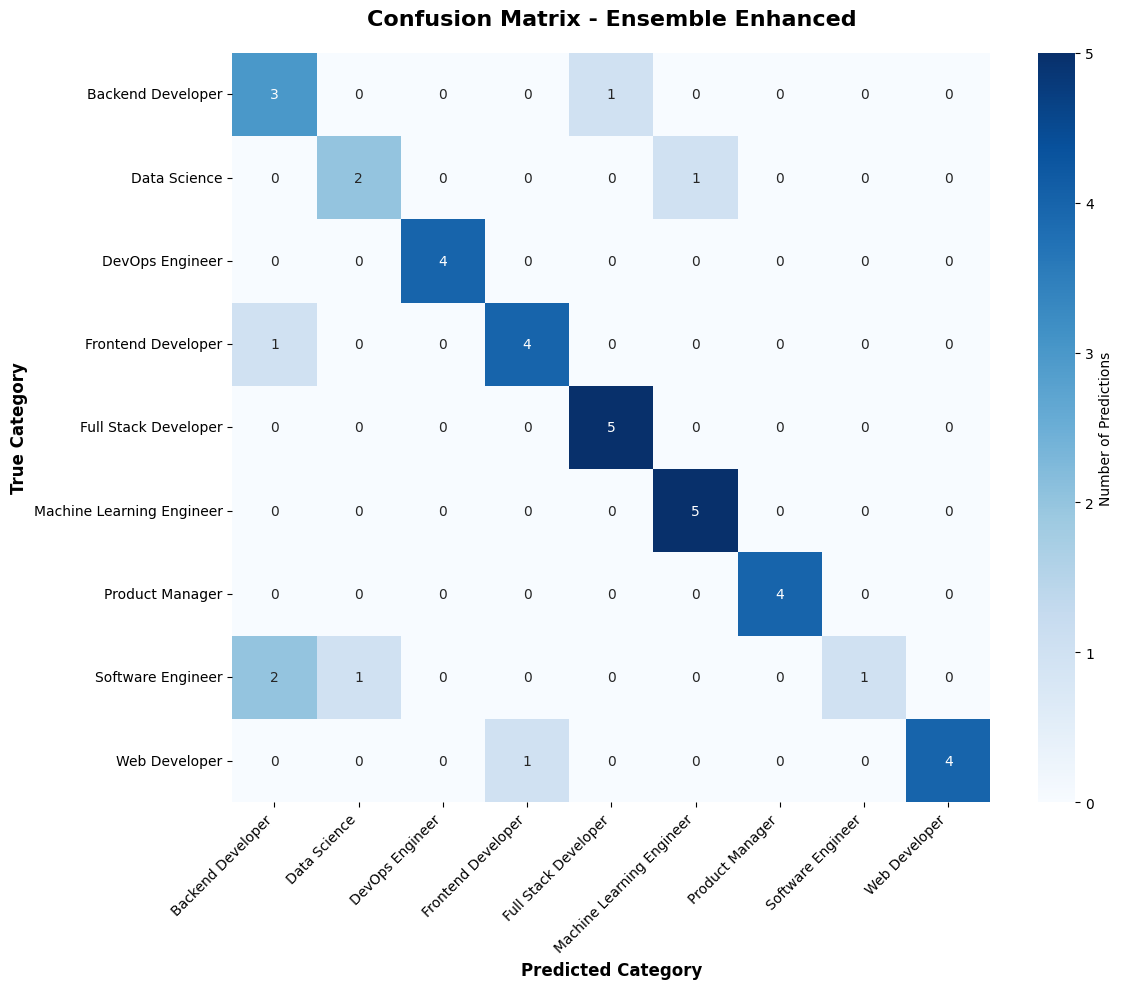


📊 Per-Class Accuracy for Ensemble Enhanced:
--------------------------------------------------
Backend Developer        : 0.7500 (75.0%)
Data Science             : 0.6667 (66.7%)
DevOps Engineer          : 1.0000 (100.0%)
Frontend Developer       : 0.8000 (80.0%)
Full Stack Developer     : 1.0000 (100.0%)
Machine Learning Engineer: 1.0000 (100.0%)
Product Manager          : 1.0000 (100.0%)
Software Engineer        : 0.2500 (25.0%)
Web Developer            : 0.8000 (80.0%)


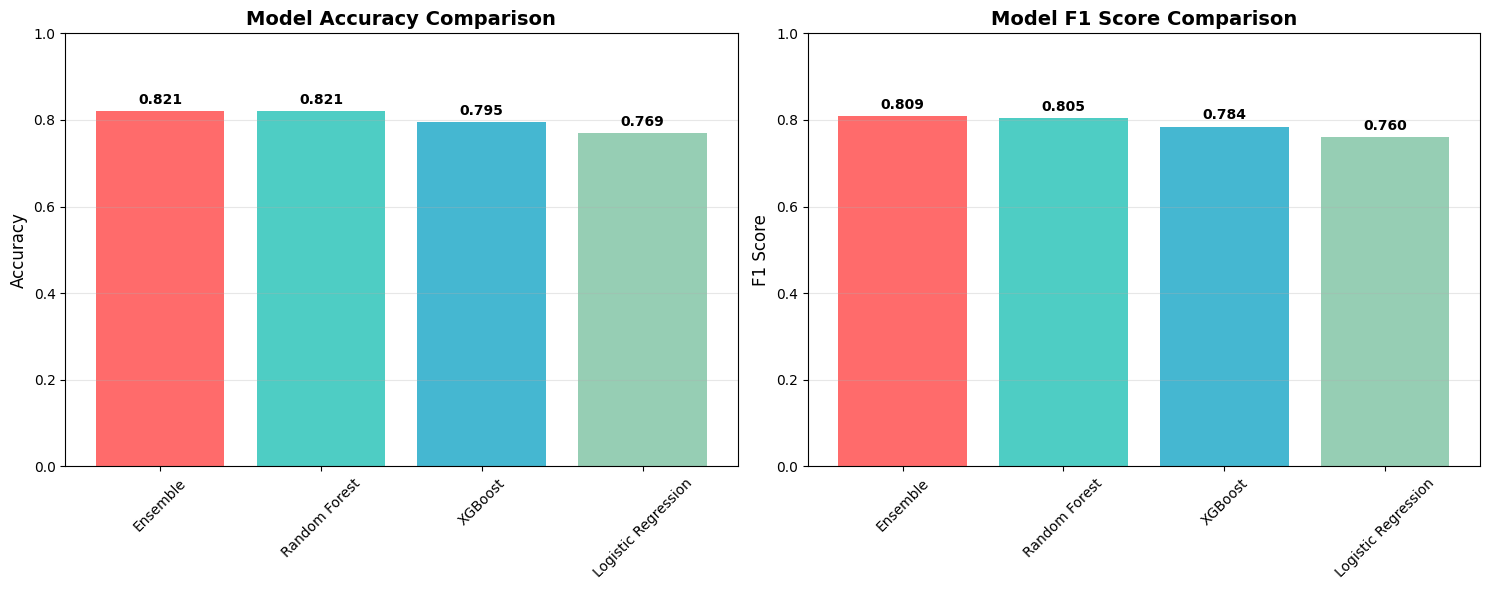

🎨 Enhanced visualizations completed!
📊 All models have been fine-tuned and evaluated with the enhanced dataset!


In [8]:
# Enhanced Visualizations and Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Function to create enhanced confusion matrix
def show_enhanced_confusion_matrix(model, model_name, X_test, y_test, label_encoder):
    """Create an enhanced confusion matrix with better styling"""
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Number of Predictions'})
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')
    plt.ylabel('True Category', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f"\n📊 Per-Class Accuracy for {model_name}:")
    print("-" * 50)
    for i, (class_name, acc) in enumerate(zip(label_encoder.classes_, class_accuracy)):
        print(f"{class_name:25s}: {acc:.4f} ({acc*100:.1f}%)")

# Display enhanced confusion matrices for all models
models_to_visualize = {
    "Logistic Regression Enhanced": enhanced_models["Logistic Regression Enhanced"],
    "Random Forest Enhanced": enhanced_models["Random Forest Enhanced"], 
    "XGBoost Enhanced": enhanced_models["XGBoost Enhanced"],
    "Ensemble Enhanced": enhanced_models["Ensemble Enhanced"]
}

for model_name, model in models_to_visualize.items():
    show_enhanced_confusion_matrix(model, model_name, X_test, y_test, label_encoder)

# Model Performance Comparison Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
model_names = [perf['Model'].replace(' Enhanced', '') for perf in model_performance]
accuracies = [perf['Accuracy'] for perf in model_performance]
f1_scores = [perf['F1_Score'] for perf in model_performance]

# Accuracy bar plot
bars1 = ax1.bar(model_names, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# F1 Score bar plot
bars2 = ax2.bar(model_names, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, f1 in zip(bars2, f1_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# Rotate x-axis labels
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("🎨 Enhanced visualizations completed!")
print("📊 All models have been fine-tuned and evaluated with the enhanced dataset!")